# Method 7 - Best Ideas Low Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[best_ideas['focus_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

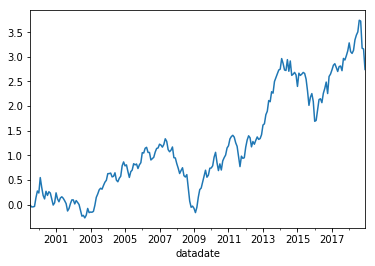

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.274472
2000-12-31   -0.187819
2001-12-31    0.057249
2002-12-31   -0.236525
2003-12-31    0.786175
2004-12-31    0.249855
2005-12-31   -0.008570
2006-12-31    0.162090
2007-12-31   -0.094551
2008-12-31   -0.502750
2009-12-31    0.795421
2010-12-31    0.236767
2011-12-31   -0.092291
2012-12-31    0.240085
2013-12-31    0.543725
2014-12-31   -0.026893
2015-12-31   -0.148390
2016-12-31    0.179648
2017-12-31    0.129540
2018-12-31   -0.091792
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     505.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.20e-112
Time:                        21:36:55   Log-Likelihood:                 560.65
No. Observations:                 234   AIC:                            -1111.
Df Residuals:                     229   BIC:                            -1094.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.002      2.487      0.014       0.001       0.007
mktrf          0.9471      0.042     22.791      0.000       0.865       1.029
me             0.7006      0.048     14.495      0.000       0.605       0.796
ia            -0.0584      0.073     -0.795      0.427      -0.203       0.086
roe           -0.5929      0.063     -9.429      0.000      -0.717      -0.469
==============================================================================
Omnibus:                       14.554   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               32.792
Skew:                           0.222   Prob(JB):                     7.57e-08
Kurtosis:                       4.780   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     387.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.02e-100
Time:                        21:36:55   Log-Likelihood:                 560.65
No. Observations:                 234   AIC:                            -1111.
Df Residuals:                     229   BIC:                            -1094.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.002      2.136      0.033       0.000       0.007
mktrf          0.9471      0.043     21.879      0.000       0.862       1.032
me             0.7006      0.075      9.328      0.000       0.553       0.848
ia            -0.0584      0.091     -0.642      0.521      -0.237       0.120
roe           -0.5929      0.074     -7.968      0.000      -0.739      -0.447
==============================================================================
Omnibus:                       14.554   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               32.792
Skew:                           0.222   Prob(JB):                     7.57e-08
Kurtosis:                       4.780   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     359.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.86e-97
Time:                        21:36:55   Log-Likelihood:                 560.65
No. Observations:                 234   AIC:                            -1111.
Df Residuals:                     229   BIC:                            -1094.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.002      2.189      0.029       0.000       0.007
mktrf          0.9471      0.042     22.565      0.000       0.865       1.029
me             0.7006      0.085      8.216      0.000       0.533       0.868
ia            -0.0584      0.082     -0.714      0.475      -0.219       0.102
roe           -0.5929      0.071     -8.355      0.000      -0.732      -0.454
==============================================================================
Omnibus:                       14.554   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               32.792
Skew:                           0.222   Prob(JB):                     7.57e-08
Kurtosis:                       4.780   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     362.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.50e-106
Time:                        21:36:55   Log-Likelihood:                 549.58
No. Observations:                 234   AIC:                            -1087.
Df Residuals:                     228   BIC:                            -1066.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.002      1.713      0.088      -0.000       0.006
mktrf          1.0450      0.044     23.888      0.000       0.959       1.131
smb            0.7569      0.058     13.112      0.000       0.643       0.871
hml           -0.0153      0.068     -0.224      0.823      -0.149       0.119
rmw           -0.4563      0.077     -5.930      0.000      -0.608      -0.305
cma            0.1089      0.098      1.113      0.267      -0.084       0.302
==============================================================================
Omnibus:                       37.735   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.511
Skew:                           0.700   Prob(JB):                     1.49e-22
Kurtosis:                       5.890   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     392.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.29e-110
Time:                        21:36:55   Log-Likelihood:                 549.58
No. Observations:                 234   AIC:                            -1087.
Df Residuals:                     228   BIC:                            -1066.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.002      1.417      0.156      -0.001       0.007
mktrf          1.0450      0.040     25.971      0.000       0.966       1.124
smb            0.7569      0.080      9.496      0.000       0.601       0.913
hml           -0.0153      0.111     -0.137      0.891      -0.233       0.203
rmw           -0.4563      0.091     -5.034      0.000      -0.634      -0.279
cma            0.1089      0.113      0.967      0.334      -0.112       0.330
==============================================================================
Omnibus:                       37.735   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.511
Skew:                           0.700   Prob(JB):                     1.49e-22
Kurtosis:                       5.890   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     446.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.34e-115
Time:                        21:36:55   Log-Likelihood:                 549.58
No. Observations:                 234   AIC:                            -1087.
Df Residuals:                     228   BIC:                            -1066.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.002      1.391      0.164      -0.001       0.007
mktrf          1.0450      0.042     24.912      0.000       0.963       1.127
smb            0.7569      0.089      8.466      0.000       0.582       0.932
hml           -0.0153      0.102     -0.150      0.881      -0.215       0.184
rmw           -0.4563      0.100     -4.567      0.000      -0.652      -0.260
cma            0.1089      0.090      1.210      0.226      -0.068       0.285
==============================================================================
Omnibus:                       37.735   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.511
Skew:                           0.700   Prob(JB):                     1.49e-22
Kurtosis:                       5.890   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     434.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.20e-105
Time:                        21:36:55   Log-Likelihood:                 544.78
No. Observations:                 234   AIC:                            -1080.
Df Residuals:                     229   BIC:                            -1062.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      1.119      0.264      -0.001       0.005
mktrf          1.0650      0.041     26.012      0.000       0.984       1.146
smb            0.9463      0.051     18.516      0.000       0.846       1.047
hml            0.0106      0.051      0.208      0.835      -0.089       0.111
umd           -0.1775      0.033     -5.328      0.000      -0.243      -0.112
==============================================================================
Omnibus:                        8.707   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               14.874
Skew:                           0.143   Prob(JB):                     0.000589
Kurtosis:                       4.202   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     372.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.29e-99
Time:                        21:36:55   Log-Likelihood:                 544.78
No. Observations:                 234   AIC:                            -1080.
Df Residuals:                     229   BIC:                            -1062.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      1.015      0.310      -0.002       0.005
mktrf          1.0650      0.042     25.547      0.000       0.983       1.147
smb            0.9463      0.092     10.320      0.000       0.767       1.126
hml            0.0106      0.093      0.113      0.910      -0.172       0.194
umd           -0.1775      0.051     -3.462      0.001      -0.278      -0.077
==============================================================================
Omnibus:                        8.707   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               14.874
Skew:                           0.143   Prob(JB):                     0.000589
Kurtosis:                       4.202   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     409.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.64e-103
Time:                        21:36:55   Log-Likelihood:                 544.78
No. Observations:                 234   AIC:                            -1080.
Df Residuals:                     229   BIC:                            -1062.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      1.060      0.289      -0.002       0.005
mktrf          1.0650      0.039     27.523      0.000       0.989       1.141
smb            0.9463      0.098      9.617      0.000       0.753       1.139
hml            0.0106      0.094      0.113      0.910      -0.173       0.194
umd           -0.1775      0.048     -3.717      0.000      -0.271      -0.084
==============================================================================
Omnibus:                        8.707   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               14.874
Skew:                           0.143   Prob(JB):                     0.000589
Kurtosis:                       4.202   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     229.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.26e-54
Time:                        21:36:55   Log-Likelihood:                 263.29
No. Observations:                 120   AIC:                            -516.6
Df Residuals:                     115   BIC:                            -502.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.003      2.205      0.029       0.001       0.011
mktrf          0.9286      0.071     13.077      0.000       0.788       1.069
me             0.7064      0.070     10.072      0.000       0.567       0.845
ia            -0.1157      0.110     -1.054      0.294      -0.333       0.102
roe           -0.5784      0.097     -5.950      0.000      -0.771      -0.386
==============================================================================
Omnibus:                        2.920   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.232   Jarque-Bera (JB):                2.975
Skew:                           0.040   Prob(JB):                        0.226
Kurtosis:                       3.767   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     224.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.50e-53
Time:                        21:36:55   Log-Likelihood:                 263.29
No. Observations:                 120   AIC:                            -516.6
Df Residuals:                     115   BIC:                            -502.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.003      1.938      0.053   -6.52e-05       0.012
mktrf          0.9286      0.067     13.883      0.000       0.797       1.060
me             0.7064      0.103      6.879      0.000       0.505       0.908
ia            -0.1157      0.124     -0.935      0.350      -0.358       0.127
roe           -0.5784      0.117     -4.926      0.000      -0.809      -0.348
==============================================================================
Omnibus:                        2.920   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.232   Jarque-Bera (JB):                2.975
Skew:                           0.040   Prob(JB):                        0.226
Kurtosis:                       3.767   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     217.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-52
Time:                        21:36:55   Log-Likelihood:                 263.29
No. Observations:                 120   AIC:                            -516.6
Df Residuals:                     115   BIC:                            -502.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.003      2.014      0.044       0.000       0.011
mktrf          0.9286      0.065     14.203      0.000       0.800       1.057
me             0.7064      0.118      5.986      0.000       0.475       0.938
ia            -0.1157      0.108     -1.072      0.284      -0.327       0.096
roe           -0.5784      0.115     -5.036      0.000      -0.804      -0.353
==============================================================================
Omnibus:                        2.920   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.232   Jarque-Bera (JB):                2.975
Skew:                           0.040   Prob(JB):                        0.226
Kurtosis:                       3.767   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     171.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.39e-51
Time:                        21:36:55   Log-Likelihood:                 260.24
No. Observations:                 120   AIC:                            -508.5
Df Residuals:                     114   BIC:                            -491.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.003      1.999      0.048    4.96e-05       0.011
mktrf          1.1036      0.077     14.306      0.000       0.951       1.256
smb            0.8009      0.087      9.167      0.000       0.628       0.974
hml           -0.0862      0.107     -0.806      0.422      -0.298       0.126
rmw           -0.3565      0.126     -2.824      0.006      -0.607      -0.106
cma            0.1413      0.138      1.022      0.309      -0.133       0.415
==============================================================================
Omnibus:                       12.724   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.906
Skew:                           0.547   Prob(JB):                     0.000129
Kurtosis:                       4.544   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     272.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-61
Time:                        21:36:55   Log-Likelihood:                 260.24
No. Observations:                 120   AIC:                            -508.5
Df Residuals:                     114   BIC:                            -491.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.003      1.743      0.081      -0.001       0.012
mktrf          1.1036      0.075     14.635      0.000       0.956       1.251
smb            0.8009      0.121      6.625      0.000       0.564       1.038
hml           -0.0862      0.168     -0.515      0.607      -0.415       0.242
rmw           -0.3565      0.162     -2.199      0.028      -0.674      -0.039
cma            0.1413      0.142      0.994      0.320      -0.137       0.420
==============================================================================
Omnibus:                       12.724   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.906
Skew:                           0.547   Prob(JB):                     0.000129
Kurtosis:                       4.544   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     335.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.09e-66
Time:                        21:36:55   Log-Likelihood:                 260.24
No. Observations:                 120   AIC:                            -508.5
Df Residuals:                     114   BIC:                            -491.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.003      1.753      0.080      -0.001       0.012
mktrf          1.1036      0.084     13.081      0.000       0.938       1.269
smb            0.8009      0.139      5.760      0.000       0.528       1.073
hml           -0.0862      0.170     -0.508      0.611      -0.419       0.246
rmw           -0.3565      0.188     -1.893      0.058      -0.726       0.013
cma            0.1413      0.114      1.235      0.217      -0.083       0.365
==============================================================================
Omnibus:                       12.724   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.906
Skew:                           0.547   Prob(JB):                     0.000129
Kurtosis:                       4.544   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     212.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.62e-52
Time:                        21:36:55   Log-Likelihood:                 259.34
No. Observations:                 120   AIC:                            -508.7
Df Residuals:                     115   BIC:                            -494.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.003      1.674      0.097      -0.001       0.010
mktrf          1.0968      0.065     16.964      0.000       0.969       1.225
smb            0.9685      0.074     13.157      0.000       0.823       1.114
hml           -0.0053      0.074     -0.072      0.942      -0.151       0.141
umd           -0.1621      0.045     -3.566      0.001      -0.252      -0.072
==============================================================================
Omnibus:                        1.488   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.475   Jarque-Bera (JB):                1.046
Skew:                          -0.021   Prob(JB):                        0.593
Kurtosis:                       3.455   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     195.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.78e-50
Time:                        21:36:55   Log-Likelihood:                 259.34
No. Observations:                 120   AIC:                            -508.7
Df Residuals:                     115   BIC:                            -494.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.003      1.752      0.080      -0.001       0.009
mktrf          1.0968      0.060     18.412      0.000       0.980       1.214
smb            0.9685      0.114      8.501      0.000       0.745       1.192
hml           -0.0053      0.128     -0.042      0.967      -0.256       0.245
umd           -0.1621      0.057     -2.824      0.005      -0.275      -0.050
==============================================================================
Omnibus:                        1.488   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.475   Jarque-Bera (JB):                1.046
Skew:                          -0.021   Prob(JB):                        0.593
Kurtosis:                       3.455   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     206.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.84e-51
Time:                        21:36:55   Log-Likelihood:                 259.34
No. Observations:                 120   AIC:                            -508.7
Df Residuals:                     115   BIC:                            -494.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.002      2.021      0.043       0.000       0.009
mktrf          1.0968      0.057     19.343      0.000       0.986       1.208
smb            0.9685      0.123      7.898      0.000       0.728       1.209
hml           -0.0053      0.133     -0.040      0.968      -0.265       0.255
umd           -0.1621      0.049     -3.295      0.001      -0.259      -0.066
==============================================================================
Omnibus:                        1.488   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.475   Jarque-Bera (JB):                1.046
Skew:                          -0.021   Prob(JB):                        0.593
Kurtosis:                       3.455   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     347.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.05e-61
Time:                        21:36:55   Log-Likelihood:                 320.17
No. Observations:                 114   AIC:                            -630.3
Df Residuals:                     109   BIC:                            -616.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      0.868      0.387      -0.002       0.004
mktrf          1.0024      0.044     22.852      0.000       0.915       1.089
me             0.6161      0.068      9.097      0.000       0.482       0.750
ia             0.0232      0.094      0.247      0.806      -0.163       0.209
roe           -0.6650      0.083     -8.056      0.000      -0.829      -0.501
==============================================================================
Omnibus:                        0.033   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.984   Jarque-Bera (JB):                0.149
Skew:                           0.031   Prob(JB):                        0.928
Kurtosis:                       2.834   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     677.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.28e-76
Time:                        21:36:55   Log-Likelihood:                 320.17
No. Observations:                 114   AIC:                            -630.3
Df Residuals:                     109   BIC:                            -616.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.786      0.432      -0.002       0.005
mktrf          1.0024      0.050     20.170      0.000       0.905       1.100
me             0.6161      0.062     10.015      0.000       0.496       0.737
ia             0.0232      0.087      0.267      0.789      -0.147       0.193
roe           -0.6650      0.063    -10.584      0.000      -0.788      -0.542
==============================================================================
Omnibus:                        0.033   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.984   Jarque-Bera (JB):                0.149
Skew:                           0.031   Prob(JB):                        0.928
Kurtosis:                       2.834   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     692.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.78e-76
Time:                        21:36:55   Log-Likelihood:                 320.17
No. Observations:                 114   AIC:                            -630.3
Df Residuals:                     109   BIC:                            -616.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.779      0.436      -0.002       0.005
mktrf          1.0024      0.043     23.420      0.000       0.918       1.086
me             0.6161      0.057     10.881      0.000       0.505       0.727
ia             0.0232      0.091      0.254      0.800      -0.156       0.202
roe           -0.6650      0.050    -13.380      0.000      -0.762      -0.568
==============================================================================
Omnibus:                        0.033   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.984   Jarque-Bera (JB):                0.149
Skew:                           0.031   Prob(JB):                        0.928
Kurtosis:                       2.834   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     231.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.26e-56
Time:                        21:36:55   Log-Likelihood:                 311.11
No. Observations:                 114   AIC:                            -610.2
Df Residuals:                     108   BIC:                            -593.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.344      0.731      -0.004       0.003
mktrf          1.0489      0.046     23.050      0.000       0.959       1.139
smb            0.6260      0.074      8.474      0.000       0.480       0.772
hml            0.0339      0.094      0.360      0.720      -0.153       0.221
rmw           -0.6119      0.115     -5.304      0.000      -0.841      -0.383
cma            0.0693      0.146      0.473      0.637      -0.221       0.360
==============================================================================
Omnibus:                        0.072   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.965   Jarque-Bera (JB):                0.110
Skew:                          -0.057   Prob(JB):                        0.947
Kurtosis:                       2.899   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     228.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.79e-56
Time:                        21:36:55   Log-Likelihood:                 311.11
No. Observations:                 114   AIC:                            -610.2
Df Residuals:                     108   BIC:                            -593.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.285      0.776      -0.004       0.003
mktrf          1.0489      0.044     23.805      0.000       0.963       1.135
smb            0.6260      0.074      8.424      0.000       0.480       0.772
hml            0.0339      0.067      0.502      0.616      -0.098       0.166
rmw           -0.6119      0.078     -7.797      0.000      -0.766      -0.458
cma            0.0693      0.120      0.578      0.564      -0.166       0.304
==============================================================================
Omnibus:                        0.072   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.965   Jarque-Bera (JB):                0.110
Skew:                          -0.057   Prob(JB):                        0.947
Kurtosis:                       2.899   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     255.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.33e-58
Time:                        21:36:55   Log-Likelihood:                 311.11
No. Observations:                 114   AIC:                            -610.2
Df Residuals:                     108   BIC:                            -593.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.272      0.785      -0.005       0.003
mktrf          1.0489      0.044     23.670      0.000       0.962       1.136
smb            0.6260      0.068      9.243      0.000       0.493       0.759
hml            0.0339      0.071      0.479      0.632      -0.105       0.173
rmw           -0.6119      0.068     -8.941      0.000      -0.746      -0.478
cma            0.0693      0.129      0.536      0.592      -0.184       0.323
==============================================================================
Omnibus:                        0.072   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.965   Jarque-Bera (JB):                0.110
Skew:                          -0.057   Prob(JB):                        0.947
Kurtosis:                       2.899   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     255.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.05e-54
Time:                        21:36:55   Log-Likelihood:                 304.23
No. Observations:                 114   AIC:                            -598.5
Df Residuals:                     109   BIC:                            -584.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.002     -0.529      0.598      -0.004       0.002
mktrf          1.0655      0.048     22.288      0.000       0.971       1.160
smb            0.7733      0.075     10.374      0.000       0.626       0.921
hml            0.0875      0.077      1.140      0.257      -0.065       0.240
umd           -0.2189      0.058     -3.779      0.000      -0.334      -0.104
==============================================================================
Omnibus:                        0.617   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.734   Jarque-Bera (JB):                0.242
Skew:                           0.020   Prob(JB):                        0.886
Kurtosis:                       3.222   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     298.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.01e-57
Time:                        21:36:55   Log-Likelihood:                 304.23
No. Observations:                 114   AIC:                            -598.5
Df Residuals:                     109   BIC:                            -584.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.002     -0.477      0.633      -0.005       0.003
mktrf          1.0655      0.047     22.647      0.000       0.973       1.158
smb            0.7733      0.084      9.192      0.000       0.608       0.938
hml            0.0875      0.072      1.208      0.227      -0.054       0.229
umd           -0.2189      0.038     -5.758      0.000      -0.293      -0.144
==============================================================================
Omnibus:                        0.617   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.734   Jarque-Bera (JB):                0.242
Skew:                           0.020   Prob(JB):                        0.886
Kurtosis:                       3.222   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     334.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.21e-60
Time:                        21:36:55   Log-Likelihood:                 304.23
No. Observations:                 114   AIC:                            -598.5
Df Residuals:                     109   BIC:                            -584.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.002     -0.429      0.668      -0.005       0.003
mktrf          1.0655      0.041     25.998      0.000       0.985       1.146
smb            0.7733      0.066     11.629      0.000       0.643       0.904
hml            0.0875      0.073      1.201      0.230      -0.055       0.230
umd           -0.2189      0.034     -6.386      0.000      -0.286      -0.152
==============================================================================
Omnibus:                        0.617   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.734   Jarque-Bera (JB):                0.242
Skew:                           0.020   Prob(JB):                        0.886
Kurtosis:                       3.222   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""